# 0. Install Dependencies and Bring in Data

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df_new = df[df['severe_toxic'] == 1]["comment_text"]
df_new.head(3)

6           COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
55     Stupid peace of shit stop deleting my stuff as...
181    you are a stupid fuck \n\nand your mother's cu...
Name: comment_text, dtype: object

# 1. Preprocess

In [5]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.2.0
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.0
anaconda-project              0.11.1
analytics-python              1.4.post1
annotated-types               0.6.0
anyio                         3.7.1
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunp


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
y.shape

(159571, 6)

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=1, validation_data=val)

 593/6981 [=>............................] - ETA: 2:39:09 - loss: 0.1240

In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

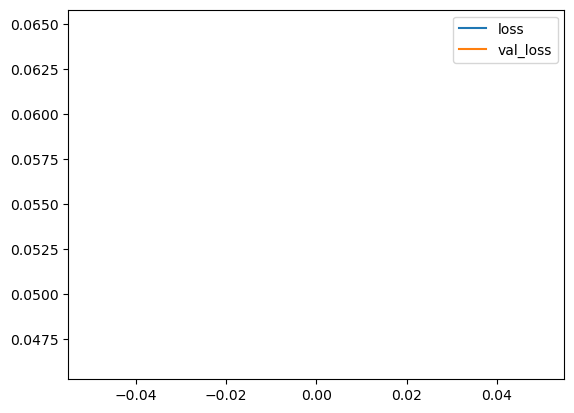

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [22]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [28]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0], dtype=int64)>

In [32]:
res= model.predict(np.array([input_text]))

1/1 [==============================] - 0s 65ms/step


In [33]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [34]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [35]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 100ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [36]:
res.shape

(1, 6)

# 4. Evaluate Model

In [37]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 103ms/step


In [40]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7874093651771545, Recall:0.699765682220459, Accuracy:0.4653961956501007


# 5. Test and Gradio

In [41]:
!pip install gradio jinja2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/50.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/50.5 kB ? eta -:--:--
     -------- ------------------------------- 10.2/50.5 kB ? eta -:--:--
     ----------------------- -------------- 30.7/50.5 kB 640.0 kB/s eta 0:00:01
     ------------------------------ ------- 41.0/50.5 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 50.5/50.5 kB 365.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/65.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/65.2 kB ? eta -:--:--
     ----------------- -------------------- 30.7/65.2 kB 262.6 kB/s eta 0:00:01
     ----------------------- -------------- 41.0/65.2 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 65.2/65.2 kB 319.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/45.7 k

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.5.2 which is incompatible.
s3fs 2023.4.0 requires fsspec==2023.4.0, but you have fsspec 2023.12.2 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
!pip install --upgrade gradio fsspec



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
!pip install gradio==2.2.14 fsspec==0.9.0


     ---------------------------------------- 0.0/3.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.4 MB 660.6 kB/s eta 0:00:06
      --------------------------------------- 0.1/3.4 MB 544.7 kB/s eta 0:00:07
      --------------------------------------- 0.1/3.4 MB 544.7 kB/s eta 0:00:07
     - -------------------------------------- 0.1/3.4 MB 435.7 kB/s eta 0:00:08
     - -------------------------------------- 0.1/3.4 MB 435.7 kB/s eta 0:00:08
     - -------------------------------------- 0.1/3.4 MB 346.5 kB/s eta 0:00:10
     - -------------------------------------- 0.1/3.4 MB 359.9 kB/s eta 0:00:10
     - -------------------------------------- 0.1/3.4 MB 359.9 kB/s eta 0:00:10
     - -------------------------------------- 0.1/3.4 MB 327.9 kB/s eta 0:00:10
     -- ------------------------------------- 0.2/3.4 MB 337.8 kB/s eta 0:00:10
     -- ------------------------------------- 0.2/3.4 MB 3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2023.6.0 requires fsspec>=2021.09.0, but you have fsspec 0.9.0 which is incompatible.
datasets 2.12.0 requires fsspec[http]>=2021.11.1, but you have fsspec 0.9.0 which is incompatible.
huggingface-hub 0.20.1 requires fsspec>=2023.5.0, but you have fsspec 0.9.0 which is incompatible.
intake 0.6.8 requires fsspec>=2021.7.0, but you have fsspec 0.9.0 which is incompatible.
s3fs 2023.4.0 requires fsspec==2023.4.0, but you have fsspec 0.9.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import tensorflow as tf
import gradio as gr

D:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [47]:
model.save('toxicity.h5')

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
model = tf.keras.models.load_model('toxicity.h5')

In [49]:
input_str = vectorizer('hey i freaken hate you!')

In [50]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 740ms/step


In [51]:
res

array([[0.82160324, 0.04780032, 0.4774333 , 0.0575807 , 0.4096053 ,
        0.07388709]], dtype=float32)

In [68]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [69]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [71]:
interface.launch(share=True)

IMPORTANT: You are using gradio version 2.2.14, however version 3.14.0 is available, please upgrade.
--------
Running locally at: http://127.0.0.1:7864/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Interface loading below...


MissingSchema: Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?